# Stock Price Prediction 

In [1]:
def add_years(d, years):
    from calendar import isleap
    new_year = d.year + years
    
    # we need to handle leap years
    try:
        return d.replace(year=new_year)
    except ValueError:
        if (d.month == 2 and d.day == 29 and # leap day
            isleap(d.year) and not isleap(new_year)):
            return d.replace(year=new_year, day=28)
        raise

In [2]:
def create_time_series(days):
    import datetime
    import pandas_datareader.data as web
    import pandas as pd
    
    #create function that gets previous business day because we may run this in weekend
    def last_business_day():
        import datetime
        import holidays

        ONE_DAY = datetime.timedelta(days=1)
        HOLIDAYS_US = holidays.US()
        next_day = datetime.date.today() - ONE_DAY
        while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
            next_day -= ONE_DAY
        return next_day

    end = last_business_day()
    start = add_years(end, -2)
    
    #read starbucks stock data
    try:
        df = web.DataReader('SBUX','yahoo', start,end)['Close']
        #create dataframe with prices of previous days as predictors
        prices = pd.Series.to_frame(df)
        for i in range(days):
            prices['Close -{}'.format(i+1)] = [0]*(i+1) + list(prices['Close'][:-(i+1)])
        return (prices[days:],prices.tail(1).iloc[:,:-1])
    except:
        return None

## Lasso Regression

In [3]:
def Lasso(data_input, alphas = None, cv=5):

    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn import linear_model
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error

    data = data_input[0]
    
    #divide data into train and test
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.Close, test_size=0.25, random_state=49)

    #fit Lasso model and find best alpha using cross validation
    model = linear_model.LassoCV(cv=5, alphas = alphas)
    model.fit(X_train, y_train)
    
    #compute MSE and R^2 of Lasso model and make prediction of tomorrows stock price
    MSE_test_data = mean_squared_error(y_test, model.predict(X_test))
    prediction_tomorrow = model.predict(data_input[1])
    score = model.score(X_test, y_test)

    # Display results
    m_log_alphas = -np.log10(model.alphas_)
    
    # plot it
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
                label='alpha: CV estimate')
    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold: coordinate descent', size = 12)
    plt.axis('tight')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.scatter(range(1, len(y_test)+1),np.array(y_test), label = 'Actual',color = 'cyan', marker="x")
    plt.scatter(range(1, len(y_test)+1),model.predict(X_test), label = 'Predicted',)

    plt.legend()
    plt.xlabel('Test Data')
    plt.ylabel('Stock Price')
    plt.title('LASSO Model Prediction Power')
    
    plt.text(-10, 64.5, 'MSE = {:.2f}'.format(MSE_test_data), style='italic',
        bbox={'facecolor':'white', 'alpha':1, 'pad':10})

    plt.show()
    
    return (MSE_test_data, score, prediction_tomorrow, [model.coef_, model.intercept_])

### Support Vector Regression

In [4]:
def SVR_stock(data_input):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    import numpy as np
    from sklearn.svm import SVR
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split

    data = data_input[0]
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.Close, test_size=0.25, random_state = 49)

    # Use grid search to find best performing SVM Parameters
    parameter_candidates1 = [
        {'C': np.logspace(-3,3, 5), 'kernel': ['linear'], 'epsilon':[0, 0.01, 0.05, 0.1]},
        {'C': np.logspace(-3,3, 5), 'kernel': ['poly'], 'epsilon':[0, 0.01, 0.05, 0.1], 'degree': list(range(2,6))}]

    names1 = {'linear':[]}

    for i,j in enumerate(names1):
        parameters = [i for i in parameter_candidates1 if [j] in i.values()]
        grid = GridSearchCV(SVR(), param_grid=parameters, cv=3)
        grid.fit(X_train, y_train)
        model = SVR(kernel= grid.best_estimator_.kernel, C=grid.best_estimator_.C, epsilon = grid.best_estimator_.epsilon)
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        score = model.score(X_test, y_test)
        mse = mean_squared_error(y_test, model.predict(X_test))
        names1[j] = [y, score, mse, model]

    parameter_candidates2 = [
        {'C':  np.logspace(-2,2, 5), 'gamma': np.logspace(-3, 3, 7), 'kernel': ['sigmoid'], 'epsilon': [0, 0.01, 0.05, 0.1]} ,
      {'C':  np.logspace(-2,2, 5), 'gamma': np.logspace(-3, 3, 7), 'kernel': ['rbf'], 'epsilon': [0, 0.01, 0.05, 0.1]}]

    names2 = {'sigmoid':[], 'rbf':[]}

    for i,j in enumerate(names2):
        #parameters = [parameter_candidates2[i]]
        parameters = [i for i in parameter_candidates2 if [j] in i.values()]
        grid = GridSearchCV(SVR(), param_grid=parameters, cv=3)
        grid.fit(X_train, y_train)
        model = SVR(kernel= grid.best_estimator_.kernel, C=grid.best_estimator_.C, epsilon = grid.best_estimator_.epsilon,
                   gamma = grid.best_estimator_.gamma )
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        score = model.score(X_test, y_test)
        mse = mean_squared_error(y_test, model.predict(X_test))
        names2[j] = [y, score, mse, model]

    names = {**names1, **names2}

    #plot results

    f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize = (15,5))

    ax1.scatter(range(1, len(y_test)+1),np.array(y_test), label = 'Actual',color = 'cyan', marker="x")
    ax1.scatter(range(1, len(y_test)+1),names['linear'][0], label = 'Predicted')
    ax1.set_xlabel('Test Data')
    ax1.set_ylabel('Stock Price')
    ax1.set_title('Performance of SVR with Linear Kernel')
    ax1.text(-10, 64.5, '$MSE = ${:.2f}'.format(names['linear'][2]), style='italic',
            bbox={'facecolor':'white', 'alpha':1, 'pad':10})
    ax1.legend()

    ax2.scatter(range(1, len(y_test)+1),np.array(y_test), label = 'Actual',color = 'cyan', marker="x")
    ax2.scatter(range(1, len(y_test)+1),names['rbf'][0], label = 'Predicted')
    ax2.set_title('Performance of SVR with RBF Kernel')
    ax2.text(-10, 64.5, '$MSE = ${:.2f}'.format(names['rbf'][2]), style='italic',
            bbox={'facecolor':'white', 'alpha':1, 'pad':10})
    ax2.legend()
    ax2.set_xlabel('Test Data')
    ax2.set_ylabel('Stock Price')

    plt.show()

    #find best performing SVR model and use it to make predicition
    best_model = min(names.values(), key=lambda x: x[2])[3]
    best_MSE = min(names.values(), key=lambda x: x[2])[2]
    stock_price_tom = best_model.predict(data_input[1])

    return (best_MSE, float(stock_price_tom), names)

In [5]:
def stock_price(days):
    
    try:
    
        import matplotlib.pyplot as plt
        import datetime
        import matplotlib.dates as mdates

        #create timeseries stock data
        data_input = create_time_series(days)

        #run predictive models on data and find which model performs better
        Lasso_model = Lasso(data_input)
        SVR_model = SVR_stock(data_input)

        if SVR_model[0] > Lasso_model[0]:
            price = Lasso_model[2][0]
        else:
            price = SVR_model[1]

        years = mdates.YearLocator()   # every year
        months = mdates.MonthLocator()  # every month
        yearsFmt = mdates.DateFormatter('%Y')

        #create function that finds next business day
        def next_business_day():

            import datetime
            import holidays

            ONE_DAY = datetime.timedelta(days=1)
            HOLIDAYS_US = holidays.US()
            next_day = datetime.date.today() + ONE_DAY
            while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
                next_day += ONE_DAY
            return next_day

        #plot stock timeseries and include prediction in plot
        data_input = create_time_series(days)
        fig, ax = plt.subplots()

        ax.plot(data_input[0]['Close'])

        ax.scatter(next_business_day(), price, c = 'cyan', s = 50)
        ax.annotate('Prediction: \n {:.2f}'.format(price), xy=(next_business_day(), price), xytext=( next_business_day() - 
                datetime.timedelta(days = 100) , price + 3), arrowprops=dict(facecolor='black', shrink=0.03))
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Price')
        ax.set_title('Starbucks Stock Price')
        plt.show()
        
    except:
        return none

## Output of Stock Prediction Function 

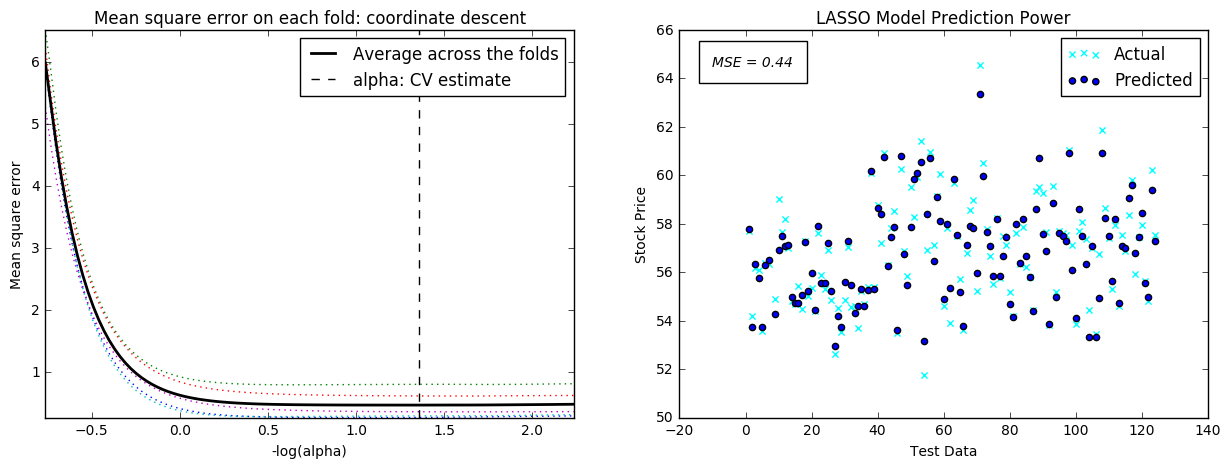

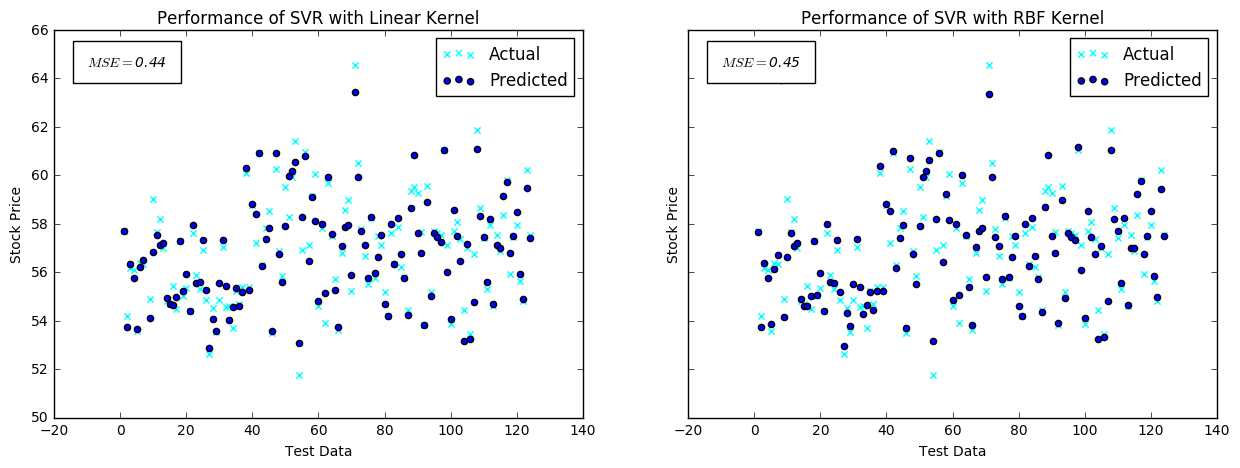

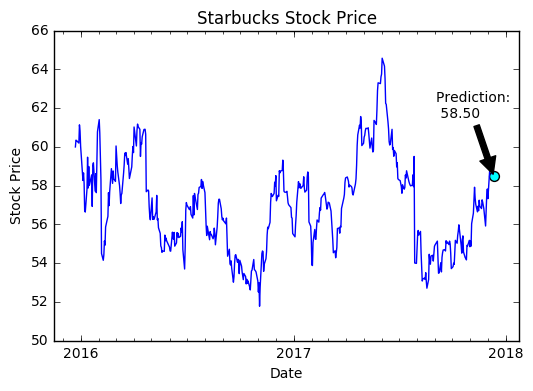

In [7]:
stock_price(10)

# Starbucks Revenue Prediction

In [8]:
def get_revenue_data():    
    import pandas as pd
    import warnings
    
    warnings.filterwarnings("ignore")

    def date_format(a):
        import datetime 
        b = {'Sept.': 'September', 'Dec.': 'December'}
        x = a.split()
        if x[0]  in b.keys():
            x[0] = b[x[0]]
            return datetime.datetime.strptime(' '.join(x),'%B %d, %Y')
        else:
            return datetime.datetime.strptime(a,'%B %d, %Y')

    df_list = pd.read_html('https://ycharts.com/companies/SBUX/revenues')
    df = df_list[0].append(df_list[1]).dropna(how='any')
    df.columns = ['Date', 'Revenue']

    df['Date'] = df['Date'].apply(lambda x: date_format(x))
    df.set_index('Date', inplace=True)
    df['Revenue'] = df['Revenue'].apply(lambda x: float(x.strip('B')))
    df.sort_index(inplace=True)
    return df

In [9]:
def create_time_series(previous_quarters):
    try:
        df = get_revenue_data()
        for i in range(previous_quarters):
            df['Quarter -{}'.format(i+1)] = [0]*(i+1) + list(df['Revenue'][:-(i+1)])
        return (df[previous_quarters:], df.tail(1).iloc[:,:-1])
    except:
        return None

In [10]:
def revenue_model():

    try:
        from sklearn import datasets, linear_model
        from sklearn.metrics import mean_squared_error, r2_score
        from sklearn.model_selection import train_test_split
        scores = dict.fromkeys(list(range(1,9)))

        #find best number of quarters to use

        for quarters in scores.keys():

            data = create_time_series(quarters)[0]

            X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.Revenue, test_size=0.1, random_state=49)

            # Create linear regression object
            regr = linear_model.LinearRegression()

            # Train the model using the training sets
            regr.fit(X_train, y_train)

            # Make predictions using the testing set
            y_pred = regr.predict(X_test)

            scores [quarters] = [r2_score(y_test, y_pred), regr]

        #make revenue prediction for next quarter based on best model
        data = create_time_series(max(scores, key=scores.get))[0]
        rev_pred = max(scores.values(), key = lambda x : x[0])[1].predict(data.iloc[:,1:])
        rev_pred_next_qrtr=max(scores.values(), key = lambda x : x[0])[1].predict(create_time_series( 
                max(scores, key=scores.get))[1])
        return [data, rev_pred, rev_pred_next_qrtr]

    except:
        return None

In [11]:
def revenue_pred():
        
    try:
        from bokeh.plotting import figure, show, output_file
        from bokeh.models.glyphs import Text
        from bokeh.charts import output_notebook
        import pandas as pd
        import datetime

        output_notebook()
        
        base_data = revenue_model()
        
        time_series = base_data[0]['Revenue']
        data = pd.Series.to_frame(time_series)
        data.columns = ['Actual Revenue']
        data['Predicted Revenue'] = revenue_model()[1]
        pred = base_data[2]
        pred_x = get_revenue_data().index[-1] + datetime.timedelta(days = 90)

        d = {'Actual Revenue': 0, 'Predicted Revenue': pred,}
        data1 = data.append(pd.DataFrame(d, index =[pred_x]))

        p1 = figure(x_axis_type="datetime", title ="Starbucks Revenue Projection", width = 900, title_text_font_size='22pt')
        p1.line(data['Actual Revenue'].index, data['Actual Revenue'], line_color="blue", line_width=2, legend = "Actual Revenue")
        p1.line(data1['Actual Revenue'].index, data1['Predicted Revenue'], 
                line_color="cyan", line_width=2, legend = "Predicted Revenue")
        p1.circle_cross([pred_x],pred, color = 'red', 
                       fill_alpha = 0.2, size = 15, line_width=2, legend = "Projected Revenue Next Quarter")
        p1.xaxis.axis_label = 'Date'
        p1.legend.location = "top_left"
        p1.yaxis.axis_label='Revenue (Billions)'
        p1.legend.glyph_height= 30
        p1.legend.glyph_width= 30
        p1.xaxis.axis_label_text_font_size = "18pt"
        p1.yaxis.axis_label_text_font_size = "18pt"
        p1.yaxis.major_label_text_font_size = "14pt"
        p1.xaxis.major_label_text_font_size = "14pt"
        show(p1)
    except:
        pass

In [12]:
revenue_pred()

Loading BokehJS ...

# Starbucks Worldwide Store Analysis

In [16]:
def get_GNI(x):

    try:
        import pandas as pd
        import numpy as np
        # webscrap GNI data
        url = 'http://www.nationsonline.org/oneworld/GNI_PPP_of_countries.htm'
        income_data = pd.read_html(url)[2].iloc[2:, [1,3]]
        income_data.columns = ['Country', 'GNI per capita (US$)']

        #clean data and make sure countries have the same name in al datasets
        income_data['GNI per capita (US$)'] = income_data['GNI per capita (US$)'].apply(
            lambda x: float(str(x).strip('*').replace(' ','')))
        income_data.loc[income_data['Country'] == 'United States', 'Country'] = 'United States of America'
        income_data.loc[income_data['Country'] == 'China (Mainland)', 'Country'] = 'China'
        income_data.dropna(how = 'any')
        income_data.loc[351] = ['Aruba', np.nan]

        a = list(x['Country'])
        b = list(income_data['Country'])

        q = [i in b for i in a]
        indices = [i for i, y in enumerate(q) if y == False]

        for j in range(len(indices)):
            for i,k in enumerate(b):
                if type(k) == str:
                    if a[indices[j]][:4] in k:
                        b[i] = a[indices[j]]

        income_data['Country'] = b          
        return income_data
    
    except:
        return None

In [17]:
def get_GDP():

    try:
        import pandas as pd
        url = 'http://www.nationmaster.com/country-info/stats/Economy/GDP-per-capita'
        gdp = pd.read_html(url)[0].iloc[:,1:3]
        gdp.columns = ['Country', 'GDP per capita (US$)']
        gdp['GDP per capita (US$)'] = gdp['GDP per capita (US$)'].apply(lambda x: float(x.strip(' $').replace(',','')))
        gdp.loc[gdp['Country'] == 'United States', 'Country'] = 'United States of America'
        gdp.loc[gdp['Country'] == 'The Bahamas', 'Country'] = 'Bahamas'
        gdp.loc[gdp['Country'] == 'Vietnam', 'Country'] = 'Viet Nam'
        return gdp
    except:
        return none

In [18]:
def create_world_data():


    from bs4 import BeautifulSoup
    import requests
    import pandas as pd
    import numpy as np

    url = 'http://www.nationsonline.org/oneworld/country_code_list.htm'
    response = requests.get(url)
    if response.status_code == 200:
        page_data_soup = BeautifulSoup(response.content,'lxml')
        countries = []
        codes = []
        x = page_data_soup.find_all('tr', {'class': "border1"})
        for i in x[1:]:
            y = i.find_all('td')[1:3]
            countries.append(y[0].get_text().strip())
            codes.append(y[1].get_text().strip())

    country_codes = {'Country' : countries, 'Country Code': codes}
    coutry_codes_df = pd.DataFrame(country_codes, columns = ['Country', 'Country Code'])

    #read starbucks store data
    starbucks_data = pd.read_csv('directory.csv')

    #find number of stores in each country
    grouped =  starbucks_data[['Brand', 'Country']].groupby('Country')
    size = grouped.agg(len)
    size.columns = ['Number of Stores']
    size['Country Code'] = size.index

    #merge country code data with starbucks data
    data_starbucks_country = pd.merge(size, coutry_codes_df, on = 'Country Code')
    data_starbucks_country.loc[data_starbucks_country['Country'] == 'Korea (South)', 'Country'] = 'South Korea'

    #get population data
    population = pd.read_html('http://www.worldometers.info/world-population/population-by-country/')[0].iloc[:,1:]
    population.columns = ['Country'] + list(population.columns[1:])
    population = population.sort_values(by=['Country'])
    population.loc[population['Country'] == 'U.K.', 'Country'] = 'United Kingdom'
    population.loc[population['Country'] == 'U.S.', 'Country'] = 'United States of America'

    #make sure countries are named the same way in all datsets

    a = list(data_starbucks_country['Country'])
    b = list(population['Country'])


    q = [i in b for i in a]
    indices = [i for i, x in enumerate(q) if x == False]

    for j in range(len(indices)):
        for i in b:
            if a[indices[j]][:3] in i:
                a[indices[j]] = i

    data_starbucks_country['Country'] = a

    #merge all datasets together

    data_final = pd.merge(data_starbucks_country, population, on = 'Country')

    data_final = data_final.replace('N.A.', np.nan).dropna()

    data_final['Starbucks per million inhabitants'] = data_final['Number of Stores']*1000000/data_final['Population (2017)']

    li = ['Yearly Change', 'Urban Pop %', 'World Share']

    for i in li:
        data_final[i] = data_final[i].apply(lambda x: float(x.strip(' %')))

    x = pd.merge(data_final, get_GDP(), on = 'Country')
    GNI_data =  get_GNI(x)

    data_ready = pd.merge(x, GNI_data, on = 'Country')
    data_ready = data_ready.dropna(how = 'any')
    data_ready[['Fert. Rate' ,'Med. Age']] = data_ready[['Fert. Rate' ,'Med. Age']].astype(float)

    return data_ready

In [19]:
def starbucks_stores():

    try:
        from bokeh.charts import Bar, output_file, show, output_notebook
        from bokeh.plotting import figure
        import warnings
    
        warnings.filterwarnings("ignore")
        
        output_notebook()

        base_data = create_world_data()

        data = base_data.sort_values(by=['Number of Stores'], ascending=False)[:20]
        data2 = base_data.sort_values(by=['Starbucks per million inhabitants'], ascending=False)[:20]

        bar = Bar(data, values='Number of Stores', label='Country', color = 'blue',
                   title="Countries with the highest number of Starbucks stores", legend = None,
                 plot_width = 900)

        # table-like data results in reconfiguration of the chart with no data manipulation
        bar2 = Bar(data2, values='Starbucks per million inhabitants', label='Country', plot_width = 900,
                   title="Countries with the highest Starbucks density", legend = None, color = 'green')

        bar.yaxis.axis_label = 'Number of Stores'
        bar2.yaxis.axis_label= 'Starbucks per million inhabitants'
        bar.xaxis.axis_label_text_font_size = "18pt"
        bar.yaxis.axis_label_text_font_size = "18pt"
        bar.yaxis.major_label_text_font_size = "14pt"
        bar.xaxis.major_label_text_font_size = "14pt"

        bar2.xaxis.axis_label_text_font_size = "18pt"
        bar2.yaxis.axis_label_text_font_size = "18pt"
        bar2.yaxis.major_label_text_font_size = "14pt"
        bar2.xaxis.major_label_text_font_size = "14pt"

        bar.title_text_font_size = "22pt"
        bar2.title_text_font_size = "22pt"

        show(bar)
        show(bar2)
    except:
        pass

## Data Visualization Output

In [21]:
starbucks_stores()

Loading BokehJS ...

In [18]:
def world_store_analysis():
    
    try:

        import numpy as np
        import statsmodels.api as sm
        from prettytable import PrettyTable
        import warnings
        import pandas as pd
    
        warnings.filterwarnings("ignore")

        base_data = create_world_data()

        #run linear regression to determine which factors affect the number of stores in a country
        X= base_data.iloc[:,3:]
        #X=base_data.iloc[:,3:]
        X = sm.add_constant(X)
        y = base_data['Number of Stores']
        model = sm.OLS(y,X,missing='drop')
        result = model.fit()

        #look at which predictors are significant
        p_values = result.pvalues[1:]
        import_variables = pd.DataFrame(p_values[p_values <= 0.065])
        import_variables['Important Predictors'] = import_variables.index
        results_final = list(import_variables['Important Predictors'])

        #print results
        t = PrettyTable(['Important Factors in Determining No. of Stores In a Country'])
        for i in results_final:
            t.add_row([i])
        
        return(t, result.summary())
        
    except:
        pass

## Output of Regression Analysis

In [19]:
q = world_store_analysis()
print(q[1])

                            OLS Regression Results                            
Dep. Variable:       Number of Stores   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     14.94
Date:                Sat, 09 Dec 2017   Prob (F-statistic):           5.97e-13
Time:                        20:27:14   Log-Likelihood:                -516.87
No. Observations:                  64   AIC:                             1062.
Df Residuals:                      50   BIC:                             1092.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

## Important Factors in Determining No. of Stores In a Country

In [20]:
print(q[0])

+-------------------------------------------------------------+
| Important Factors in Determining No. of Stores In a Country |
+-------------------------------------------------------------+
|                      Population (2017)                      |
|                        Yearly Change                        |
|                        Migrants (net)                       |
|                         World Share                         |
|              Starbucks per million inhabitants              |
|                     GDP per capita (US$)                    |
|                     GNI per capita (US$)                    |
+-------------------------------------------------------------+


## Deeper analysis in the US using California as a representative State

In [21]:
def cali_data():

    try:
        import pandas as pd
        url1 = 'https://github.com/ali-ce/datasets/blob/master/Starbucks/Starbucks%20in%20California%20-%20City%20Stats.csv'
        california_data = pd.read_html(url1)[0].iloc[:,1:].dropna(how = 'any')
        california_data['Median Household Income'] = california_data['Median Household Income'].apply(lambda x: 
                        float(x.strip(' $').replace(',','')))
        california_data.iloc[:,4:] = california_data.iloc[:,4:].astype(float)
        california_data.columns = list(california_data.columns[:8])+['Population']+list(california_data.columns[9:])
        return california_data
    except:
        return none

In [31]:
def cali_store_analysis():
    
    try:

        from bokeh.charts import Bar, output_file, show, output_notebook
        from bokeh.plotting import figure
        import numpy as np
        import statsmodels.api as sm
        from prettytable import PrettyTable
        import pandas as pd

        output_notebook()

        base_data = cali_data()

        data2 = base_data.sort_values(by=['Starbucks per million inhabitants'], ascending=False)[:20]

        # table-like data results in reconfiguration of the chart with no data manipulation
        bar2 = Bar(data2, values='Starbucks per million inhabitants', label='County', plot_width = 900,
                   title="Counties with the highest Starbucks density", legend = None, color = 'green')

        bar2.yaxis.axis_label= 'Starbucks per million inhabitants'
        
        bar2.xaxis.axis_label_text_font_size = "18pt"
        bar2.yaxis.axis_label_text_font_size = "18pt"
        bar2.yaxis.major_label_text_font_size = "14pt"
        bar2.xaxis.major_label_text_font_size = "14pt"

        bar2.title_text_font_size = "22pt"

        #run linear regression to determine which factors affect the number of stores in a country
        X= base_data.iloc[:,6:11]
        X = sm.add_constant(X)
        y = base_data['Number of Starbucks']
        model = sm.OLS(y,X,missing='drop')
        result = model.fit()

        #look at which predictors are significant
        p_values = result.pvalues[1:]
        import_variables = pd.DataFrame(p_values[p_values <= 0.1])
        import_variables['Important Predictors'] = import_variables.index
        results_final = list(import_variables['Important Predictors'])

        #print results
        t = PrettyTable(['Important Factors in Determining No. of Stores In a City in California'])
        for i in results_final:
            t.add_row([i])

        return(show(bar2), t, result.summary())

    except:
        pass

## Output of California Analysis

In [33]:
q = cali_store_analysis()
print(q[0], q[1])

Loading BokehJS ...

None +------------------------------------------------------------------------+
| Important Factors in Determining No. of Stores In a City in California |
+------------------------------------------------------------------------+
|                        Median Household Income                         |
|                               Population                               |
|                     Percentage of white population                     |
|                         Land Area (Sq. miles)                          |
+------------------------------------------------------------------------+
